##  UQ, part 1: Bert-based recommendation 

What we do in this project:
1. Using MC dropout (keep dropout during testing) and DL ensemble (using different random seeds for several runs) to quantify the uncertainty (mean and variance) together with performance metrics (AUC, PRAUC, precision@k, recall@k) for BERT
2. compared with original/more deterministic version
3. using temperatural scaling for tuning the results before and after
4. scroll down to the very bottom for the specific cases of (tuning) uq (? maybe let's see)
5. cleaned version see the notebook with prefix 'clean_'

6. **added contents compared to just UQ: 1) extra metrics calculations based on UQ results: either multiply or weighted average; 2) everything plot together in the calibration plot**

In [84]:
# library import 
#general 
import os
import argparse
import pickle
import dill
import logging

#you cannot live without 
from tqdm import trange
import pandas as pd
import numpy as np
from scipy.special import softmax
import time
import random
from termcolor import colored
from sklearn.feature_extraction.text import TfidfVectorizer

#pip install transformers
#pytorch related
import torch
import torch.nn as nn
import torch.nn.functional as F

#bert related
from transformers import BertModel, BertTokenizer, BertForSequenceClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

#self-defined
import sys
import calibration_library.visualization as visual
import calibration_library.recalibration as recalib
import utils 

# parent sibling folder 
sys.path.append('../../')
# grant-BERT related
import part0_GrantRec.utils_bert as ut
from part0_GrantRec.utils_bert import flat_accuracy,flat_accuracy, format_time, set_seed, train_batch, evaluate_batch, save_model, plot_train
from part0_GrantRec.rfa_bert import GrantModel
from part0_GrantRec.eval_metrics import Metrics
from part0_GrantRec.dataProcessing_bert_uq import RFADataProcess as DP #modfiy to take a subset for testing

torch.autograd.set_detect_anomaly(True)

In [112]:
# define arguments
"""
we should be able to choose optins between mc dropout (testing: each 5) or ensembles: shuffle data and random each time: M=5
plot of calibration 
"""
#training 
parser = argparse.ArgumentParser(description = 'UQ for BERT rec')
parser.add_argument('-data_path', type = str, default = '../part0_GrantRec/newdata/', 
                    help = 'complete path to the training data [default:../part0_GrantRec/newdata/]')
parser.add_argument('-load_pretrained', type = bool, default = False,
                    help = 'wehther to load pretrained, if False, would train, otherwise directly test[default:False]')
parser.add_argument('-load_path', type = str, default = 'res_bert/', 
                    help = """path where fine-tuned bert embeddings & tokenizer  
                           are saved [default:res_bert /]""")
parser.add_argument('-newSplit', type = bool, default = True, 
                    help = """whether split the data for MRR calculation [default: True]""")
parser.add_argument('-cuda_device', type = int, default = 1, 
                    help = 'if has cuda, device number to be used [default:1]')
parser.add_argument('-learning_rate', type = float, default = 2e-5, 
                    help = 'learning rate of Bert model optimizer [default:2e-5]')
parser.add_argument('-epsilon', type = float, default = 1e-8, 
                    help = 'epsilon of Bert model optimizer [default:1e-8]')
parser.add_argument('-train_epochs', type = int, default = 4, 
                    help = 'fine tune epoch numbers [default: 4]')
parser.add_argument('-plot_train', type = bool, default = True, 
                    help = 'Whether to plot training stats [default: True]')
# only for debugging purpose
parser.add_argument('-subsampled', type = bool, default = False, 
                    help = 'Whether to subsample loaders for debugging [default: False]')

# UQ
# seed control 
parser.add_argument('-startSeed', type = int, default = 2022, 
                    help = 'random control seed [default: 2022]')
# mutually exclusive groups, either doing MC dropout or ensemble, or regular
parser.add_argument('-uqOption', type = str, default = 'mcdrop', 
                    help = "options for uq, choose from ['mcdrop', 'ensemble', 'regular'], regular = no uq")
parser.add_argument('-ens_repeat', type = int, default = 5, 
                    help = 'times to repeat for ensemble [default: 5]')
parser.add_argument('-mcd_repeat', type = int, default = 100, 
                    help = 'times to repeat for mcdrop [default: 100]')

# calibration
parser.add_argument('-temp_scale', type = bool, default = False, 
                    help = 'Whether to do post-training temperature scaling[default: False]')
# which way to adjust results
parser.add_argument('-uqAdjusted', type = str, default = 'multiply', 
                    help = 'Whether to do uq adjusted results [default: multiply], other options include weighted_avg')
parser.add_argument('-alpha1', type = float, default = 0.8, 
                    help = 'weight for original logits for weighted_avg uqAdjusted[default:0.8]')
parser.add_argument('-alpha2', type = float, default = 0.2, 
                    help = 'weight for ci for weighted_avg uqAdjusted[default:0.2]')
parser.add_argument('-plot_calib', type = bool, default = True, 
                    help = "whether to plot calibration for current 3 options: [no Uq, uqOption, uqOption adjusted]\
                            [default:True]")

args = parser.parse_args([])

In [5]:
# overall 
def main(args):
    
    logging.basicConfig(level=logging.ERROR, filename=args.load_path + "logfile", filemode="a+",
                            format="%(asctime)-15s %(levelname)-8s %(message)s")
    logger = logging.getLogger('UQ new experiment')
    handler = logging.FileHandler(args.load_path + "logfile")
    logger.addHandler(handler)
    logger.error('UQ new experiment')

    try: 
            # data 
            ut.set_seed(args.startSeed)
            dp =  DP(path= args.data_path,
                      load_pretrained = args.load_pretrained, 
                      load_path = args.load_path,
                      newSplit = args.newSplit,
                      subsampled = args.subsampled)
            dp.dataframize_()

            train_loader, valid_loader, test_loader, _ = dp.dataloaderize_() #dataloader right here  
            if torch.cuda.is_available():
                use_cuda = torch.device('cuda:' + str(args.cuda_device))
            else:
                use_cuda = torch.device('cpu')

            # control just one model (for mc dropout or regular)
            # or multiple models (for ensemble)
            if args.uqOption.lower() == 'ensemble':
                n_runs = args.ens_repeat
            else:
                # mcdrop or regular 
                n_runs = 1

            for i in range(0, n_runs):
                # save in separate folder for later
                load_path = args.load_path + args.uqOption + str(i) + '/'
                combo = GrantModel(load_pretrained = args.load_pretrained, load_path = load_path)
                model = combo.model
                # tokenizer = combo.tokenizer
                model.to(use_cuda)

                if not args.load_pretrained:

                    optimizer = AdamW(model.parameters(),
                                      lr = args.learning_rate,
                                      eps = args.epsilon)

                    total_steps = len(train_loader) * args.train_epochs
                    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                                num_training_steps = total_steps)

                    # for MC dropout, no changes during training, but for ensemble, need to switch seeds and save model 5 times 
                    # have the seed as part of the model_saving
                    training_stats, model = ut.train_uq(epochs = args.train_epochs, model = model,
                                                        train_loader = train_loader, valid_loader = valid_loader, \
                                                        optimizer = optimizer, scheduler = scheduler, use_cuda = use_cuda,\
                                                        i = i+ args.startSeed, load_path =load_path,\
                                                        tokenizer = dp.tokenizer, logger = logger, option = args.uqOption)
                    if args.plot_train:
                        ut.plot_train(training_stats, load_path)

                # we're doing T = 100 predictions if mcdrop 
                # or 1 prediciton for just one run of ensemble
                if args.uqOption.lower() == 'mcdrop':
                    n_test = args.mcd_repeat
                else:
                    # ensemble or regular 
                    n_test = 1

                logits_np, labels_np, std, confidences = ut.predictions_uq(model = model, \
                                                                                 test_loader = test_loader, \
                                                                                 use_cuda = use_cuda, \
                                                                                 path = load_path, T = n_test)
                citation_df = pd.read_csv(args.data_path + 'citation_data_test.csv')

            # uptill here, we have one set of resultss saved, or ens_repeat = 5 sets of test results saved 
            if args.uqOption.lower() == 'ensemble':
                # take all results together and averged
                pred_ls = []
                for i in range(args.ens_repeat):
                    bef = args.load_path + args.uqOption + str(i) + '/'
                    pred = np.load(bef + 'combine_predictions.npy')
                    pred_ls.append(np.expand_dims(pred, axis=0))
                logits_np = np.mean(pred_ls, axis = 0)
                logits_np = np.squeeze(logits_np, axis=0)
                load_path =  args.load_path + args.uqOption 
                std = np.std(pred_ls, axis = 0)
                np.save(load_path + 'std.npy', std)

            similarity_dict, max_leng = ut.create_smilarity_dict(citation_df = citation_df, 
                                                             combine_predictions = logits_np, 
                                                             save_path = load_path)
            # for ROCAUC, AP, r@1, calibration should not affect this metrics
            utils.perform_clf(logits_np = logits_np, labels_np = labels_np, \
                              load_path = load_path, logger = logger)
            utils.perform_rec(dp = dp, similarity_dict = similarity_dict, logger = logger)
            # calibration plots
            utils.calib_res(logits_np = logits_np, labels_np = labels_np,\
                                        load_path = load_path, logger = logger )
            if args.temp_scale:
                # scale everything 
                scaled_logits_np = utils.temperature_scale(model = model , use_cuda = use_cuda, \
                                                           valid_loader = valid_loader, logits_np_test = logits_np)
                # similar with previous 
                load_path = load_path + 'scaled_'          
                utils.calib_res(logits_np = scaled_logits_np, labels_np = labels_np ,\
                                            load_path = load_path, logger = logger)
                # back 
                load_path = load_path[:-7]
            
            # calculate UQ adjusted results 
            if args.uqOption.lower() == 'mcdrop':
                n = args.mcd_repeat 
                std = np.load(load_path + 'std.npy')
            else:
                n = args.ens_repeat
            ci = std/np.sqrt(n) * 1.96 * 2.
            new_logits_np = utils.recalculate_score(y_logits = logits_np, 
                                                    y_ci = ci, 
                                                    option = args.uqAdjusted, alpha1 = args.alpha1, alpha2 = args.alpha2)
            
            # repeat results calculation 
            logger.error('UQ adjusted result {}'.format(args.uqAdjusted))
            new_load_path = load_path + args.uqAdjusted
            similarity_dict, max_leng = ut.create_smilarity_dict(citation_df = citation_df, 
                                                             combine_predictions = new_logits_np, 
                                                             save_path = new_load_path)
            utils.perform_clf(logits_np = new_logits_np, labels_np = labels_np, \
                              load_path = new_load_path, logger = logger)
            utils.perform_rec(dp = dp, similarity_dict = similarity_dict, logger = logger)
            utils.calib_res(logits_np = new_logits_np, labels_np = labels_np,\
                                        load_path = new_load_path, logger = logger)
            
            # finally plot every thing together
            if args.plot_calib:
                names = ['No UQ', args.uqOption, args.uqOption + ' ' + args.uqAdjusted]
                # labels and predicted logits
                logits_bsl = np.load( '../part0_GrantRec/model_uq/combine_predictions.npy') #previous experimentation path
                y_probs = [logits_bsl, logits_np,  new_logits_np]
                y_probs_new = [softmax(v, axis =1) for v in y_probs]
                
                utils.combine_calibration_plot(names = names, 
                                               y_test = labels_np, y_probs = y_probs_new, 
                                               markers = ['*', 's', 'o'], fstyles = ['full','full','None'], bins = 20, \
                                               title_name = 'bert_based', \
                                               additional_title = 'No UQ (*), before (◼) and after(○) UQ adjusted', \
                                               save_path = args.load_path)
            
    except KeyboardInterrupt:
            print(colored('--' * 70, 'green'))
            print(colored('Exiting from training early', 'green'))  
            
    logging.shutdown()

mixed pairs dataframe loaded
corpus loaded


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
  Batch   200  of  27,115.    Elapsed: 0:01:12.
  Batch   400  of  27,115.    Elapsed: 0:02:23.
  Batch   600  of  27,115.    Elapsed: 0:03:34.
  Batch   800  of  27,115.    Elapsed: 0:04:45.
  Batch 1,000  of  27,115.    Elapsed: 0:05:56.
  Batch 1,200  of  27,115.    Elapsed: 0:07:08.
  Batch 1,400  of  27,115.    Elapsed: 0:08:19.
  Batch 1,600  of  27,115.    Elapsed: 0:09:30.
  Batch 1,800  of  27,115.    Elapsed: 0:10:41.
  Batch 2,000  of  27,115.    Elapsed: 0:11:53.
  Batch 2,200  of  27,115.    Elapsed: 0:13:04.
  Batch 2,400  of  27,115.    Elapsed: 0:14:16.
  Batch 2,600  of  27,115.    Elapsed: 0:15:27.
  Batch 2,800  of  27,115.    Elapsed: 0:16:39.
  Batch 3,000  of  27,115.    Elapsed: 0:17:50.
  Batch 3,200  of  27,115.    Elapsed: 0:19:01.
  Batch 3,400  of  27,115.    Elapsed: 0:20:13.
  Batch 3,600  of  27,115.    Elapsed: 0:21:24.
  Batch 3,800  of  27,115.    Elapsed: 0:22:35.
  Batch 4,000  of  27,115.    Elapsed: 0:23:4

  Batch 5,600  of  27,115.    Elapsed: 0:33:19.
  Batch 5,800  of  27,115.    Elapsed: 0:34:30.
  Batch 6,000  of  27,115.    Elapsed: 0:35:41.
  Batch 6,200  of  27,115.    Elapsed: 0:36:52.
  Batch 6,400  of  27,115.    Elapsed: 0:38:03.
  Batch 6,600  of  27,115.    Elapsed: 0:39:14.
  Batch 6,800  of  27,115.    Elapsed: 0:40:25.
  Batch 7,000  of  27,115.    Elapsed: 0:41:36.
  Batch 7,200  of  27,115.    Elapsed: 0:42:47.
  Batch 7,400  of  27,115.    Elapsed: 0:43:58.
  Batch 7,600  of  27,115.    Elapsed: 0:45:09.
  Batch 7,800  of  27,115.    Elapsed: 0:46:20.
  Batch 8,000  of  27,115.    Elapsed: 0:47:31.
  Batch 8,200  of  27,115.    Elapsed: 0:48:42.
  Batch 8,400  of  27,115.    Elapsed: 0:49:53.
  Batch 8,600  of  27,115.    Elapsed: 0:51:05.
  Batch 8,800  of  27,115.    Elapsed: 0:52:16.
  Batch 9,000  of  27,115.    Elapsed: 0:53:26.
  Batch 9,200  of  27,115.    Elapsed: 0:54:38.
  Batch 9,400  of  27,115.    Elapsed: 0:55:49.
  Batch 9,600  of  27,115.    Elapsed: 0

  Batch 11,200  of  27,115.    Elapsed: 1:06:00.
  Batch 11,400  of  27,115.    Elapsed: 1:07:11.
  Batch 11,600  of  27,115.    Elapsed: 1:08:21.
  Batch 11,800  of  27,115.    Elapsed: 1:09:32.
  Batch 12,000  of  27,115.    Elapsed: 1:10:43.
  Batch 12,200  of  27,115.    Elapsed: 1:11:54.
  Batch 12,400  of  27,115.    Elapsed: 1:13:04.
  Batch 12,600  of  27,115.    Elapsed: 1:14:15.
  Batch 12,800  of  27,115.    Elapsed: 1:15:26.
  Batch 13,000  of  27,115.    Elapsed: 1:16:36.
  Batch 13,200  of  27,115.    Elapsed: 1:17:47.
  Batch 13,400  of  27,115.    Elapsed: 1:18:58.
  Batch 13,600  of  27,115.    Elapsed: 1:20:09.
  Batch 13,800  of  27,115.    Elapsed: 1:21:19.
  Batch 14,000  of  27,115.    Elapsed: 1:22:30.
  Batch 14,200  of  27,115.    Elapsed: 1:23:41.
  Batch 14,400  of  27,115.    Elapsed: 1:24:51.
  Batch 14,600  of  27,115.    Elapsed: 1:26:02.
  Batch 14,800  of  27,115.    Elapsed: 1:27:13.
  Batch 15,000  of  27,115.    Elapsed: 1:28:23.
  Batch 15,200  of  

  Batch 16,800  of  27,115.    Elapsed: 1:40:03.
  Batch 17,000  of  27,115.    Elapsed: 1:41:14.
  Batch 17,200  of  27,115.    Elapsed: 1:42:25.
  Batch 17,400  of  27,115.    Elapsed: 1:43:36.
  Batch 17,600  of  27,115.    Elapsed: 1:44:47.
  Batch 17,800  of  27,115.    Elapsed: 1:45:58.
  Batch 18,000  of  27,115.    Elapsed: 1:47:09.
  Batch 18,200  of  27,115.    Elapsed: 1:48:21.
  Batch 18,400  of  27,115.    Elapsed: 1:49:32.
  Batch 18,600  of  27,115.    Elapsed: 1:50:43.
  Batch 18,800  of  27,115.    Elapsed: 1:51:54.
  Batch 19,000  of  27,115.    Elapsed: 1:53:05.
  Batch 19,200  of  27,115.    Elapsed: 1:54:15.
  Batch 19,400  of  27,115.    Elapsed: 1:55:26.
  Batch 19,600  of  27,115.    Elapsed: 1:56:37.
  Batch 19,800  of  27,115.    Elapsed: 1:57:48.
  Batch 20,000  of  27,115.    Elapsed: 1:58:58.
  Batch 20,200  of  27,115.    Elapsed: 2:00:09.
  Batch 20,400  of  27,115.    Elapsed: 2:01:20.
  Batch 20,600  of  27,115.    Elapsed: 2:02:31.
  Batch 20,800  of  

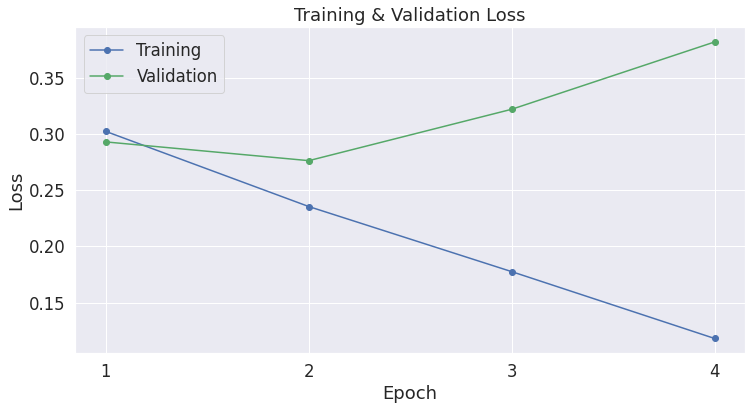

...DONE.
Test Accuracy: 0.928


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
  Batch   200  of  27,115.    Elapsed: 0:01:12.
  Batch   400  of  27,115.    Elapsed: 0:02:23.
  Batch   600  of  27,115.    Elapsed: 0:03:34.
  Batch   800  of  27,115.    Elapsed: 0:04:45.
  Batch 1,000  of  27,115.    Elapsed: 0:05:56.
  Batch 1,200  of  27,115.    Elapsed: 0:07:08.
  Batch 1,400  of  27,115.    Elapsed: 0:08:19.
  Batch 1,600  of  27,115.    Elapsed: 0:09:30.
  Batch 1,800  of  27,115.    Elapsed: 0:10:41.
  Batch 2,000  of  27,115.    Elapsed: 0:11:52.
  Batch 2,200  of  27,115.    Elapsed: 0:13:03.
  Batch 2,400  of  27,115.    Elapsed: 0:14:14.
  Batch 2,600  of  27,115.    Elapsed: 0:15:25.
  Batch 2,800  of  27,115.    Elapsed: 0:16:36.
  Batch 3,000  of  27,115.    Elapsed: 0:17:48.
  Batch 3,200  of  27,115.    Elapsed: 0:19:00.
  Batch 3,400  of  27,115.    Elapsed: 0:20:13.
  Batch 3,600  of  27,115.    Elapsed: 0:21:26.
  Batch 3,800  of  27,115.    Elapsed: 0:22:39.
  Batch 4,000  of  27,115.    Elapsed: 0:23:5

  Batch 5,600  of  27,115.    Elapsed: 0:33:01.
  Batch 5,800  of  27,115.    Elapsed: 0:34:12.
  Batch 6,000  of  27,115.    Elapsed: 0:35:23.
  Batch 6,200  of  27,115.    Elapsed: 0:36:33.
  Batch 6,400  of  27,115.    Elapsed: 0:37:44.
  Batch 6,600  of  27,115.    Elapsed: 0:38:55.
  Batch 6,800  of  27,115.    Elapsed: 0:40:06.
  Batch 7,000  of  27,115.    Elapsed: 0:41:17.
  Batch 7,200  of  27,115.    Elapsed: 0:42:27.
  Batch 7,400  of  27,115.    Elapsed: 0:43:38.
  Batch 7,600  of  27,115.    Elapsed: 0:44:49.
  Batch 7,800  of  27,115.    Elapsed: 0:46:00.
  Batch 8,000  of  27,115.    Elapsed: 0:47:11.
  Batch 8,200  of  27,115.    Elapsed: 0:48:21.
  Batch 8,400  of  27,115.    Elapsed: 0:49:32.
  Batch 8,600  of  27,115.    Elapsed: 0:50:43.
  Batch 8,800  of  27,115.    Elapsed: 0:51:54.
  Batch 9,000  of  27,115.    Elapsed: 0:53:04.
  Batch 9,200  of  27,115.    Elapsed: 0:54:15.
  Batch 9,400  of  27,115.    Elapsed: 0:55:25.
  Batch 9,600  of  27,115.    Elapsed: 0

  Batch 11,200  of  27,115.    Elapsed: 1:05:59.
  Batch 11,400  of  27,115.    Elapsed: 1:07:09.
  Batch 11,600  of  27,115.    Elapsed: 1:08:20.
  Batch 11,800  of  27,115.    Elapsed: 1:09:31.
  Batch 12,000  of  27,115.    Elapsed: 1:10:42.
  Batch 12,200  of  27,115.    Elapsed: 1:11:52.
  Batch 12,400  of  27,115.    Elapsed: 1:13:03.
  Batch 12,600  of  27,115.    Elapsed: 1:14:14.
  Batch 12,800  of  27,115.    Elapsed: 1:15:24.
  Batch 13,000  of  27,115.    Elapsed: 1:16:35.
  Batch 13,200  of  27,115.    Elapsed: 1:17:46.
  Batch 13,400  of  27,115.    Elapsed: 1:18:56.
  Batch 13,600  of  27,115.    Elapsed: 1:20:07.
  Batch 13,800  of  27,115.    Elapsed: 1:21:17.
  Batch 14,000  of  27,115.    Elapsed: 1:22:28.
  Batch 14,200  of  27,115.    Elapsed: 1:23:39.
  Batch 14,400  of  27,115.    Elapsed: 1:24:50.
  Batch 14,600  of  27,115.    Elapsed: 1:26:00.
  Batch 14,800  of  27,115.    Elapsed: 1:27:11.
  Batch 15,000  of  27,115.    Elapsed: 1:28:22.
  Batch 15,200  of  

  Batch 16,800  of  27,115.    Elapsed: 1:39:13.
  Batch 17,000  of  27,115.    Elapsed: 1:40:24.
  Batch 17,200  of  27,115.    Elapsed: 1:41:35.
  Batch 17,400  of  27,115.    Elapsed: 1:42:46.
  Batch 17,600  of  27,115.    Elapsed: 1:43:57.
  Batch 17,800  of  27,115.    Elapsed: 1:45:08.
  Batch 18,000  of  27,115.    Elapsed: 1:46:19.
  Batch 18,200  of  27,115.    Elapsed: 1:47:30.
  Batch 18,400  of  27,115.    Elapsed: 1:48:41.
  Batch 18,600  of  27,115.    Elapsed: 1:49:51.
  Batch 18,800  of  27,115.    Elapsed: 1:51:02.
  Batch 19,000  of  27,115.    Elapsed: 1:52:13.
  Batch 19,200  of  27,115.    Elapsed: 1:53:24.
  Batch 19,400  of  27,115.    Elapsed: 1:54:35.
  Batch 19,600  of  27,115.    Elapsed: 1:55:46.
  Batch 19,800  of  27,115.    Elapsed: 1:56:57.
  Batch 20,000  of  27,115.    Elapsed: 1:58:08.
  Batch 20,200  of  27,115.    Elapsed: 1:59:19.
  Batch 20,400  of  27,115.    Elapsed: 2:00:30.
  Batch 20,600  of  27,115.    Elapsed: 2:01:41.
  Batch 20,800  of  

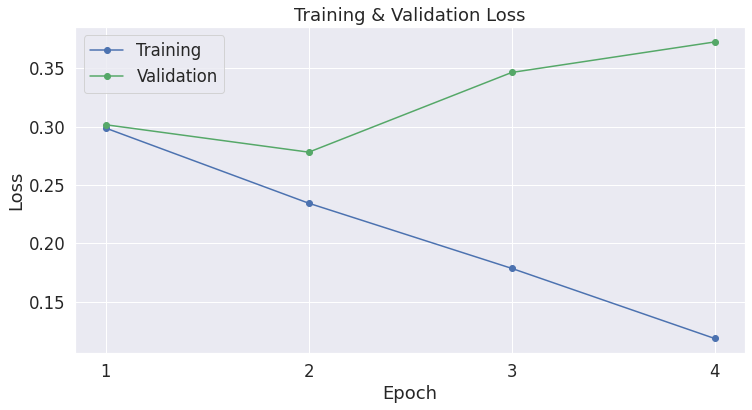

...DONE.
Test Accuracy: 0.927


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
  Batch   200  of  27,115.    Elapsed: 0:01:13.
  Batch   400  of  27,115.    Elapsed: 0:02:24.
  Batch   600  of  27,115.    Elapsed: 0:03:36.
  Batch   800  of  27,115.    Elapsed: 0:04:47.
  Batch 1,000  of  27,115.    Elapsed: 0:05:58.
  Batch 1,200  of  27,115.    Elapsed: 0:07:09.
  Batch 1,400  of  27,115.    Elapsed: 0:08:20.
  Batch 1,600  of  27,115.    Elapsed: 0:09:31.
  Batch 1,800  of  27,115.    Elapsed: 0:10:42.
  Batch 2,000  of  27,115.    Elapsed: 0:11:53.
  Batch 2,200  of  27,115.    Elapsed: 0:13:05.
  Batch 2,400  of  27,115.    Elapsed: 0:14:16.
  Batch 2,600  of  27,115.    Elapsed: 0:15:27.
  Batch 2,800  of  27,115.    Elapsed: 0:16:38.
  Batch 3,000  of  27,115.    Elapsed: 0:17:49.
  Batch 3,200  of  27,115.    Elapsed: 0:19:00.
  Batch 3,400  of  27,115.    Elapsed: 0:20:11.
  Batch 3,600  of  27,115.    Elapsed: 0:21:22.
  Batch 3,800  of  27,115.    Elapsed: 0:22:33.
  Batch 4,000  of  27,115.    Elapsed: 0:23:4

  Batch 5,600  of  27,115.    Elapsed: 0:33:09.
  Batch 5,800  of  27,115.    Elapsed: 0:34:21.
  Batch 6,000  of  27,115.    Elapsed: 0:35:32.
  Batch 6,200  of  27,115.    Elapsed: 0:36:43.
  Batch 6,400  of  27,115.    Elapsed: 0:37:54.
  Batch 6,600  of  27,115.    Elapsed: 0:39:05.
  Batch 6,800  of  27,115.    Elapsed: 0:40:16.
  Batch 7,000  of  27,115.    Elapsed: 0:41:27.
  Batch 7,200  of  27,115.    Elapsed: 0:42:38.
  Batch 7,400  of  27,115.    Elapsed: 0:43:49.
  Batch 7,600  of  27,115.    Elapsed: 0:45:00.
  Batch 7,800  of  27,115.    Elapsed: 0:46:11.
  Batch 8,000  of  27,115.    Elapsed: 0:47:22.
  Batch 8,200  of  27,115.    Elapsed: 0:48:33.
  Batch 8,400  of  27,115.    Elapsed: 0:49:45.
  Batch 8,600  of  27,115.    Elapsed: 0:50:56.
  Batch 8,800  of  27,115.    Elapsed: 0:52:07.
  Batch 9,000  of  27,115.    Elapsed: 0:53:18.
  Batch 9,200  of  27,115.    Elapsed: 0:54:29.
  Batch 9,400  of  27,115.    Elapsed: 0:55:40.
  Batch 9,600  of  27,115.    Elapsed: 0

In [ ]:
if __name__ == "__main__":
    main(args)

In [ ]:
####ater all experiments 
ut.plot_all(args, num =3)
ut.plot_all(args, num =5)